<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/CC_BY.png"><br />

Created by [Nathan Kelber](http://nkelber.com) and Ted Lawless for [JSTOR Labs](https://labs.jstor.org/) under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/)<br />
For questions/comments/improvements, email nathan.kelber@ithaka.org.<br />
____
# Exploring Word Frequencies

**Description:**
This [notebook](https://docs.constellate.org/key-terms/#jupyter-notebook) shows how to find the most common words in a
[dataset](https://docs.constellate.org/key-terms/#dataset). The following processes are described:

* Using the `tdm_client` to create a Pandas DataFrame
* Filtering based on a pre-processed ID list
* Filtering based on a [stop words list](https://docs.constellate.org/key-terms/#stop-words)
* Using a `Counter()` object to get the most common words

**Use Case:** For Learners (Detailed explanation, not ideal for researchers)

[Take me to the **Research Version** of this notebook ->](./exploring-word-frequencies-for-research.ipynb)

**Difficulty:** Intermediate

**Completion time:** 60 minutes

**Knowledge Required:** 
* Python Basics ([Start Python Basics I](./python-basics-1.ipynb))

**Knowledge Recommended:**

* [Working with Dataset Files](./working-with-dataset-files.ipynb)
* [Pandas I](./pandas-1.ipynb)
* [Counter Objects](./counter-objects.ipynb)
* [Creating a Stopwords List](./creating-stopwords-list.ipynb)

**Data Format:** [JSON Lines (.jsonl)](https://docs.constellate.org/key-terms/#jsonl)

**Libraries Used:**
* **[tdm_client](https://docs.constellate.org/key-terms/#tdm-client)** to collect, unzip, and read our dataset
* **[NLTK](https://docs.constellate.org/key-terms/#nltk)** to help [clean](https://docs.constellate.org/key-terms/#clean-data) up our dataset
* [Counter](https://docs.constellate.org/key-terms/#python-counter) from **Collections** to help sum up our word frequencies

**Research Pipeline:**

1. Build a dataset
2. Create a "Pre-Processing CSV" with [Exploring Metadata](./exploring-metadata.ipynb) (Optional)
3. Create a "Custom Stopwords List" with [Creating a Stopwords List](./creating-stopwords-list.ipynb) (Optional)
4. Complete the word frequencies analysis with this notebook
___

## Import your dataset

We'll use the tdm_client library to automatically retrieve the dataset in the JSON file format. 

Enter a [dataset ID](https://docs.constellate.org/key-terms/#dataset-ID) in the next code cell.

If you don't have a dataset ID, you can:
* Use the sample dataset ID already in the code cell
* [Create a new dataset](https://constellate.org/builder)
* [Use a dataset ID from other pre-built sample datasets](https://constellate.org/dataset/dashboard)

In [1]:
# Creating a variable `dataset_id` to hold our dataset ID
# The default dataset is Shakespeare Quarterly, 1950-present
dataset_id = "8526f5fb-402e-90db-c713-c0c7afd0edcd"

Next, import the `tdm_client`, passing the `dataset_id` as an argument using the `get_dataset` method.

In [2]:
# Importing your dataset with a dataset ID
import constellate
# Pull in the sampled dataset (1500 documents) that matches `dataset_id`
# in the form of a gzipped JSON lines file.
# The .get_dataset() method downloads the gzipped JSONL file
# to the /data folder and returns a string for the file name and location
#dataset_file = constellate.get_dataset(dataset_id)

# To download the full dataset (up to a limit of 25,000 documents),
# request it first in the builder environment. See the Constellate Client
# documentation at: https://constellate.org/docs/constellate-client
# Then use the `constellate.download` method show below.
dataset_file = constellate.download(dataset_id, 'jsonl')

Constellate: use and download of datasets is covered by the Terms & Conditions of Use: https://constellate.org/terms-and-conditions/
"foster care" AND (adopt* OR reunification OR reunifies OR reunify) from JSTOR or Portico from 1950 - 2021. 21441 documents.
INFO:root:Downloading 8cd2db4b-fe27-5ea0-3f89-3f9da1b29dce metadata to /root/data/8cd2db4b-fe27-5ea0-3f89-3f9da1b29dce-jsonl.jsonl.gz


100% |########################################################################|


## Apply Pre-Processing Filters (if available)
If you completed pre-processing with the "Exploring Metadata and Pre-processing" notebook, you can use your CSV file of dataset IDs to automatically filter the dataset. Your pre-processed CSV file should be in the /data directory.

In [3]:
# Import a pre-processed CSV file of filtered dataset IDs.
# If you do not have a pre-processed CSV file, the analysis
# will run on the full dataset and may take longer to complete.
import pandas as pd
import os

# Define a string that describes the path to the CSV
#pre_processed_file_name = f'data/pre-processed_{dataset_id}.csv'
pre_processed_file_name = f'data/{dataset_id}-metadata-filtered.csv'

# Test if the path to the CSV exists
# If true, then read the IDs into filtered_id_list
if os.path.exists(pre_processed_file_name):
    df = pd.read_csv(pre_processed_file_name)
    filtered_id_list = df["id"].tolist()
    use_filtered_list = True
    print(f'Pre-Processed CSV found. Filtered dataset is ' + str(len(df)) + ' documents.')
else: 
    use_filtered_list = False
    print('No pre-processed CSV file found. Full dataset will be used.')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
Pre-Processed CSV found. Filtered dataset is 17131 documents.


## Modified Unigram Collection with Decade

This next section includes some tweaks on the Constellate ungram collection sections Word Frequencies notebooks, so we can capture the decade.

In [4]:
# Import Counter()
from collections import Counter

# Create an empty Counter object called `word_frequency`
word_frequency = Counter()

### Load Stopwords List

If you have created a stopword list in the stopwords notebook, we will import it here. (You can always modify the CSV file to add or subtract words then reload the list.) Otherwise, we'll load the NLTK [stopwords](https://docs.constellate.org/key-terms/#stop-words) list automatically.

In [5]:
# Load a custom data/stop_words.csv if available
# Otherwise, load the nltk stopwords list in English

# Create an empty Python list to hold the stopwords
stop_words = []

# The filename of the custom data/stop_words.csv file
stopwords_list_filename = 'data/stop_words.csv'

if os.path.exists(stopwords_list_filename):
    import csv
    with open(stopwords_list_filename, 'r') as f:
        stop_words = list(csv.reader(f))[0]
    print('Custom stopwords list loaded from CSV')
else:
    # Load the NLTK stopwords list
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    print('NLTK stopwords list loaded')


NLTK stopwords list loaded


### Gather unigrams again with extra cleaning steps
In addition to using a stopwords list, we will clean up the tokens by lowercasing all tokens and combining them. This will combine tokens with different capitalization such as "quarterly" and "Quarterly." We will also remove any tokens that are not alphanumeric.

In [6]:
# Gather unigramCounts from documents in `filtered_id_list` if available
# and apply the processing.

word_frequency_decade = Counter()
word_frequency = Counter()

for document in constellate.dataset_reader(dataset_file):
    if use_filtered_list is True:
        document_id = document['id']
        # Skip documents not in our filtered_id_list
        if document_id not in filtered_id_list:
            continue
    
    # Here we are grabbing the publicationYear from the Constellate dataset file and turning it into a decade.
    d_year = document.get("publicationYear")
    d_decade = str(d_year)[0:3] + "0"
    
    unigrams = document.get("unigramCount", [])
    
    # After cleaning up the 'gram' add it to our Counter
    for gram, count in unigrams.items():
        clean_gram = gram.lower()
        if clean_gram in stop_words:
            continue
        if not clean_gram.isalpha():
            continue
        if not len(clean_gram) >2:
            continue
        
        # when adding the 'gram' to our Counter, append the decade
        word_frequency_decade[clean_gram + " " + d_decade] += count
        word_frequency[clean_gram] += count
        

# Print success message
if use_filtered_list is True:
    print('Unigrams have been collected only for the ' + str(len(df)) + ' documents listed in your CSV file.')
else:
    print('Unigrams have been collected for all documents without filtering from a CSV file.')

Unigrams have been collected only for the 17131 documents listed in your CSV file.


## Display Results
Finally, we will display the 20 most common words by using the `.most_common()` method on the `Counter()` object.

In [7]:
# Print the most common processed unigrams and their counts
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

social               900218
children             812167
child                689792
family               554977
may                  533054
also                 521716
one                  466238
new                  456446
research             422052
health               405928
care                 392410
work                 369367
would                343931
state                299650
many                 289407
study                275149
people               273091
use                  265276
journal              258319
university           257943
parents              256863
see                  252251
two                  247690
foster               246846
public               243131


And for comparison purposes, here are the towp 25 in our by decade Counter.

In [8]:
# Print the most common processed unigrams and their counts
for gram, count in word_frequency_decade.most_common(25):
    print(gram.ljust(20), count)

social 2010          437275
children 2010        367247
child 2010           275608
also 2010            272129
children 2000        248347
research 2010        240865
may 2010             237607
new 2010             224923
family 2010          224630
one 2010             220809
health 2010          218169
social 2000          213382
child 2000           211614
work 2010            192401
care 2010            183399
family 2000          168367
people 2010          161804
university 2010      148835
study 2010           144325
many 2010            143569
would 2010           143494
state 2010           138301
use 2010             137921
may 2000             132659
social 1990          129868


## Export Results to a CSV File
The word frequency data can be exported to a CSV file.

In [9]:
# Add output method to csv
import csv

# write out top 1000 in the decade spreadsheet

with open(f'./data/word_frequencies_{dataset_id}.decade.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['unigram', 'decade', 'count'])
    
    # Figure out the 1000 most common words in the dataset over all
    top_grams = []
    for gram, count in word_frequency.most_common(1000):
        top_grams.append(gram)
    
    for gram_decade, count in word_frequency_decade.most_common():
        gram, decade = gram_decade.split()
        
        if gram in top_grams:
            writer.writerow([gram,decade, count])

with open(f'./data/word_frequencies_{dataset_id}.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['unigram', 'decade', 'count'])
    for grame, count in word_frequency.most_common():
        writer.writerow([gram, count])

## Create a Word Cloud to Visualize the Data
A visualization using the WordCloud library in Python. To learn more about customizing a wordcloud, [see the documentation](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html). 

In [10]:
# Add wordcloud
from wordcloud import WordCloud
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
### Download cloud image for our word cloud shape
import urllib.request
download_url = 'https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/sample_cloud.png'
urllib.request.urlretrieve(download_url, './data/sample_cloud.png')

('./data/sample_cloud.png', <http.client.HTTPMessage at 0x7ff0797f8160>)

Word Cloud for All Time in Dataset


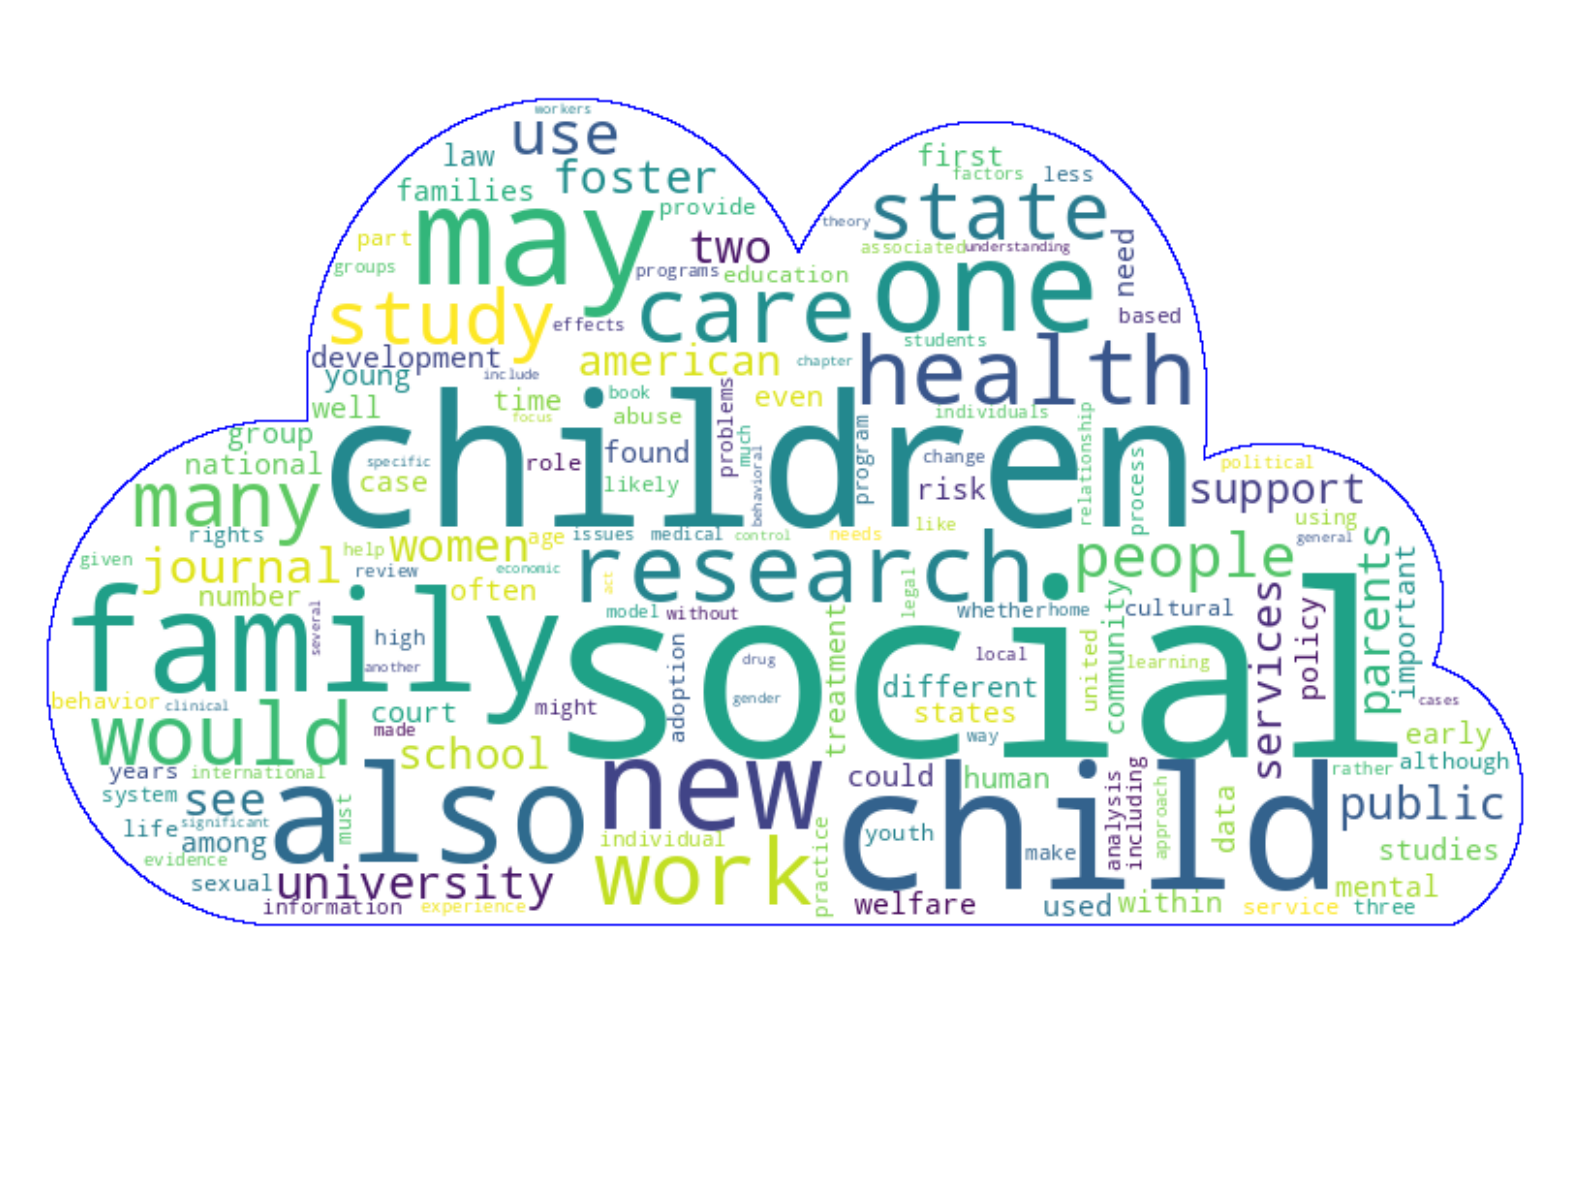

In [12]:
# Create a wordcloud from our data

print("Word Cloud for All Time in Dataset")

# Adding a mask shape of a cloud to your word cloud
# By default, the shape will be a rectangle
# You can specify any shape you like based on an image file
cloud_mask = np.array(Image.open('./data/sample_cloud.png')) # Specifies the location of the mask shape
cloud_mask = np.where(cloud_mask > 3, 255, cloud_mask) # this line will take all values greater than 3 and make them 255 (white)


wordcloud = WordCloud(
    width = 800, # Change the pixel width of the image if blurry
    height = 600, # Change the pixel height of the image if blurry
    background_color = "white", # Change the background color
    colormap = 'viridis', # The colors of the words, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    max_words = 150, # Change the max number of words shown
    min_font_size = 4, # Do not show small text
    
    # Add a shape and outline (known as a mask) to your wordcloud
    contour_color = 'blue', # The outline color of your mask shape
    mask = cloud_mask, # 
    contour_width = 1
).generate_from_frequencies(word_frequency)

mpl.rcParams['figure.figsize'] = (20,20) # Change the image size displayed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()